#Предобработка данных

In [1]:
import pandas as pd
# sklearn - набор инструментов для машинного обучения.
# feature_extraction.text - извлечение признаков из текста, с последующим 
# моделированием. В данном случае моделирование не требуется. Необходимо просто 
# получить биграммы и их оценку
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
 
# Библиотека для визуализации данных
import matplotlib.pyplot as plt
 
# Модуль математических функций
import math

import pandas as pd
import numpy as np
%pylab inline
from scipy import stats
import statsmodels.api as sm
from itertools import product
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import MDS, TSNE
from sklearn.metrics import pairwise_distances
from sklearn import linear_model, metrics, model_selection
import warnings
import matplotlib.patches as mpatches
import os

!pip install razdel
from razdel import tokenize

Populating the interactive namespace from numpy and matplotlib
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
df = pd.read_excel('vacance.xlsx')
df = df.drop('Unnamed: 0',axis = 1)
df.sample(frac=1).reset_index(drop = True)
vacancies_name = df.name
skills = df.skills

In [3]:
chars = ["'",']','[',',']
def tokenize_1(text):
    for char in chars:
      text = text.replace(char,'') 
    return list(map(lambda x: x.text, tokenize(text)))

In [4]:
rer = []
for sk in df.skills:
  rer.append(sk.split(sep=','))
df.skillss = rer
data_token = []
for sk in df.skillss:
  qq = []
  for one in sk:
      qq.append(tokenize_1(one))
  data_token.append(qq)

<ipython-input-4-6c7b1c963233>:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.skillss = rer


In [11]:
skill_n = []
skill_v = []
id = []
for item,line in enumerate(df.name):
  for sk in data_token[item]:
    q = str()
    for s in sk:
      q+=s
      q+=' '
    if q > '':
      skill_n.append(q)
      skill_v.append(line)
      id.append(df.iloc[item].id)
skills = pd.DataFrame({'name': skill_v, 'skill': skill_n,'id':id})
skills.skill.astype('string')
skills.rename(columns = {'name':'name_sk'},inplace = True)

#Формирование вектора для каждой вакансии

In [8]:
skill_list = list(set(np.array(skills.skill)))
print('Количество уникальных скилов в базе данных вакансий',len(skill_list))
count = []
for i in skill_list:
  count.append(list(skills.skill).count(i))
count_p = pd.DataFrame({'skill': skill_list, 'countt': count})
sk_filtr = count_p[count_p['countt']>5]
sk_filtr.countt=(sk_filtr.countt-sk_filtr.countt.min())/(sk_filtr.countt.max()-sk_filtr.countt.min())
sk_filtr.reset_index(drop = True, inplace = True)

Количество уникальных скилов в базе данных вакансий 7080


<ipython-input-8-163de26a93f2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sk_filtr.countt=(sk_filtr.countt-sk_filtr.countt.min())/(sk_filtr.countt.max()-sk_filtr.countt.min())


In [9]:
def get_vector_filtr(sk,fuature_sk,count):
  vector = [0]*len(fuature_sk)
  if len(sk)>4:
    q = 0.2/(len(sk)-3)
    mass = np.append([0.5,0.2,0.1,],[q]*(len(sk)-3))
  elif len(sk)==4:
    mass = [0.5,0.25,0.15,0.1]
  elif len(sk)==3:
    mass = [0.6,0.3,0.1]
  elif len(sk)==2:
    mass = [0.7,0.3]
  else:
    mass = [1]
  for index,item1 in enumerate(sk):
    for item2,j in enumerate(fuature_sk):
      if item1 == j:
        vector[item2]=(3*mass[index]+count[item2])/7
  return vector

In [12]:
sk = []
id = []
vector = []
for i in range(1,skills.shape[0]):
  if skills.iloc[i].id == skills.iloc[i-1].id or sk == []:
    sk.append(skills.iloc[i].skill)
  else:
    vector.append(get_vector_filtr(sk,list(sk_filtr.skill),list(sk_filtr.countt)))
    id.append(skills.iloc[i].id)
    sk = []

df_i = df.copy()
df_i.set_index('id',inplace = True)
vector = np.array(vector)

#Отсеивание неинформативных векторов
vec = vector.copy()
id_c = id.copy()
vector,id = [],[]
for item,v in enumerate(vec):
  if v.sum()>0.25:
    vector.append(v)
    id.append(id_c[item])
vector = np.array(vector)

#Сравнение методов понижения размерности

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


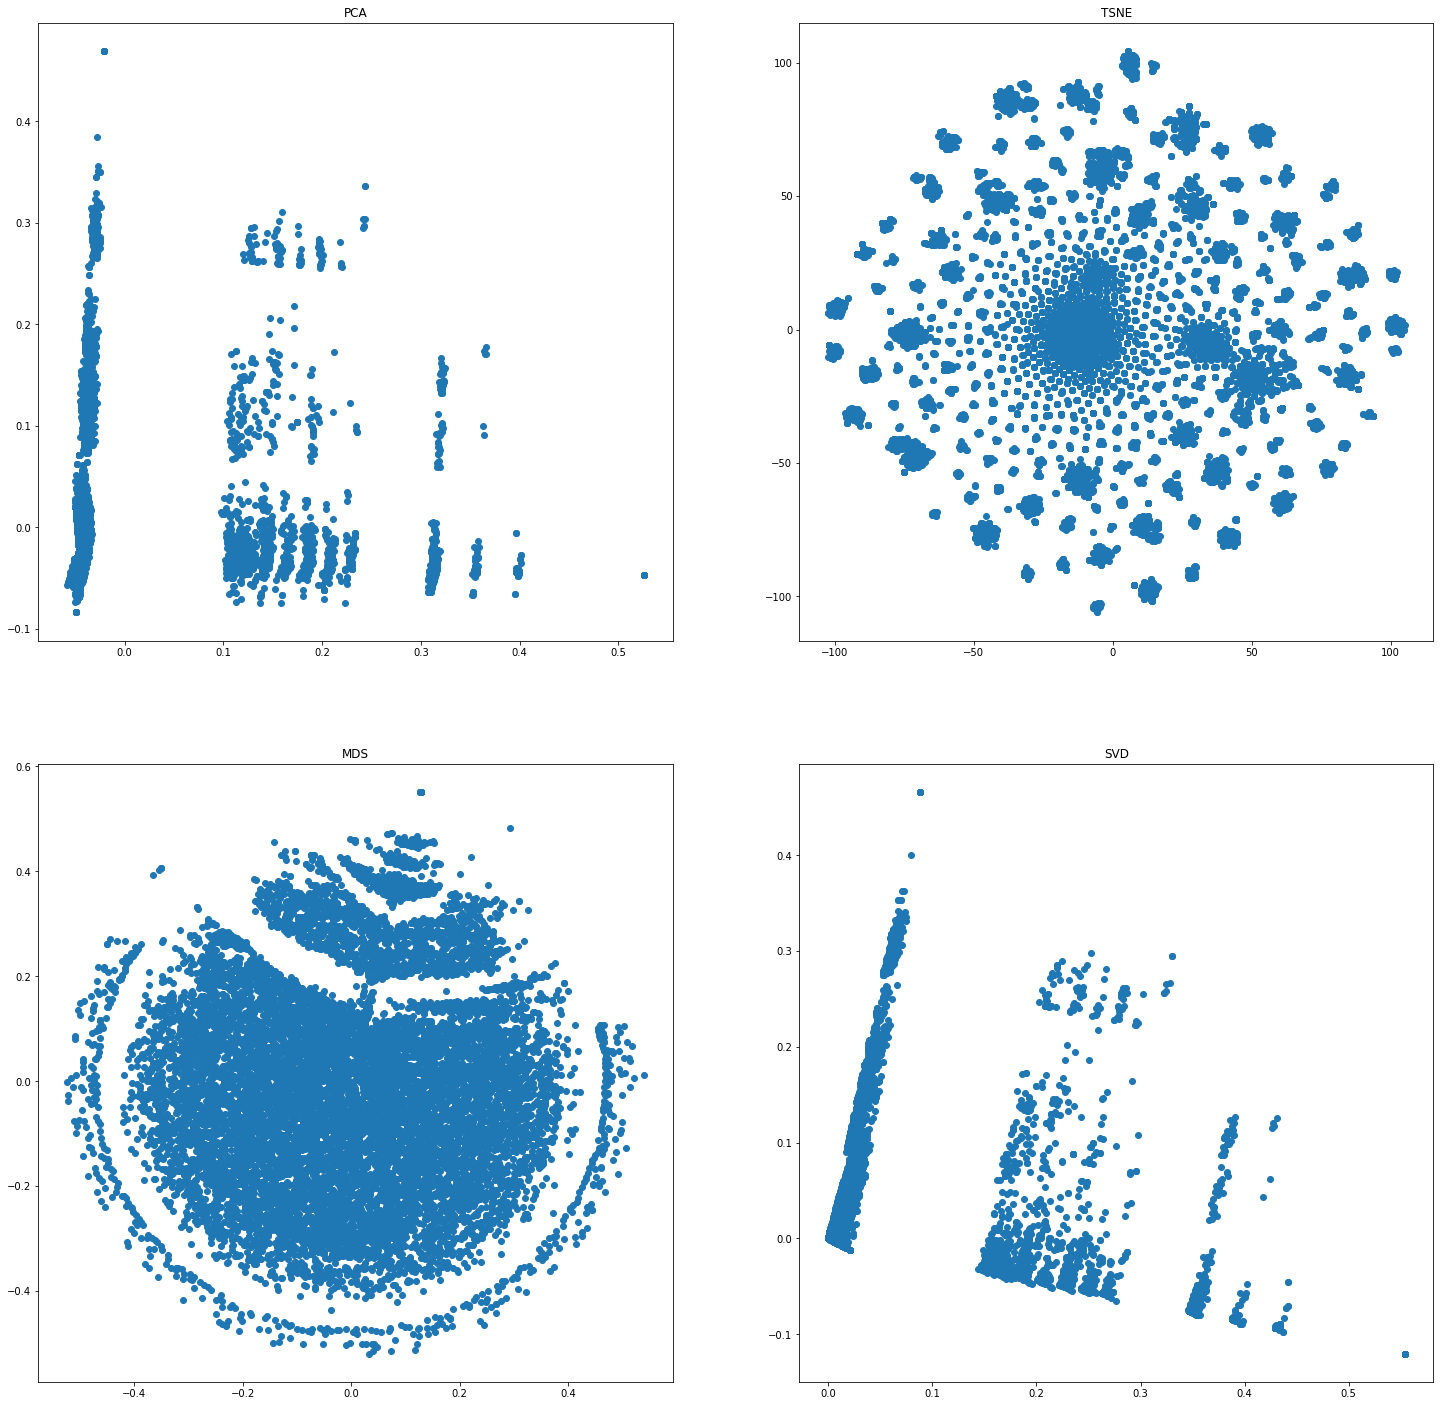

In [15]:
fig, axs = plt.subplots(2,2, figsize=(25,25))
random_state = 0
methods = [PCA(2, random_state = random_state), MDS(2, random_state = random_state),
           TSNE(2, random_state = random_state),TruncatedSVD(2, random_state = random_state)]
titles = ['PCA', 'MDS', 'TSNE', 'SVD']
for i in range(len(titles)):
    model = methods[i].fit_transform(vector)
    ax = axs[i%2,i//2]
    ax.scatter([j[0] for j in model],[j[1] for j in model])
    ax.set_title(titles[i])

#GMM

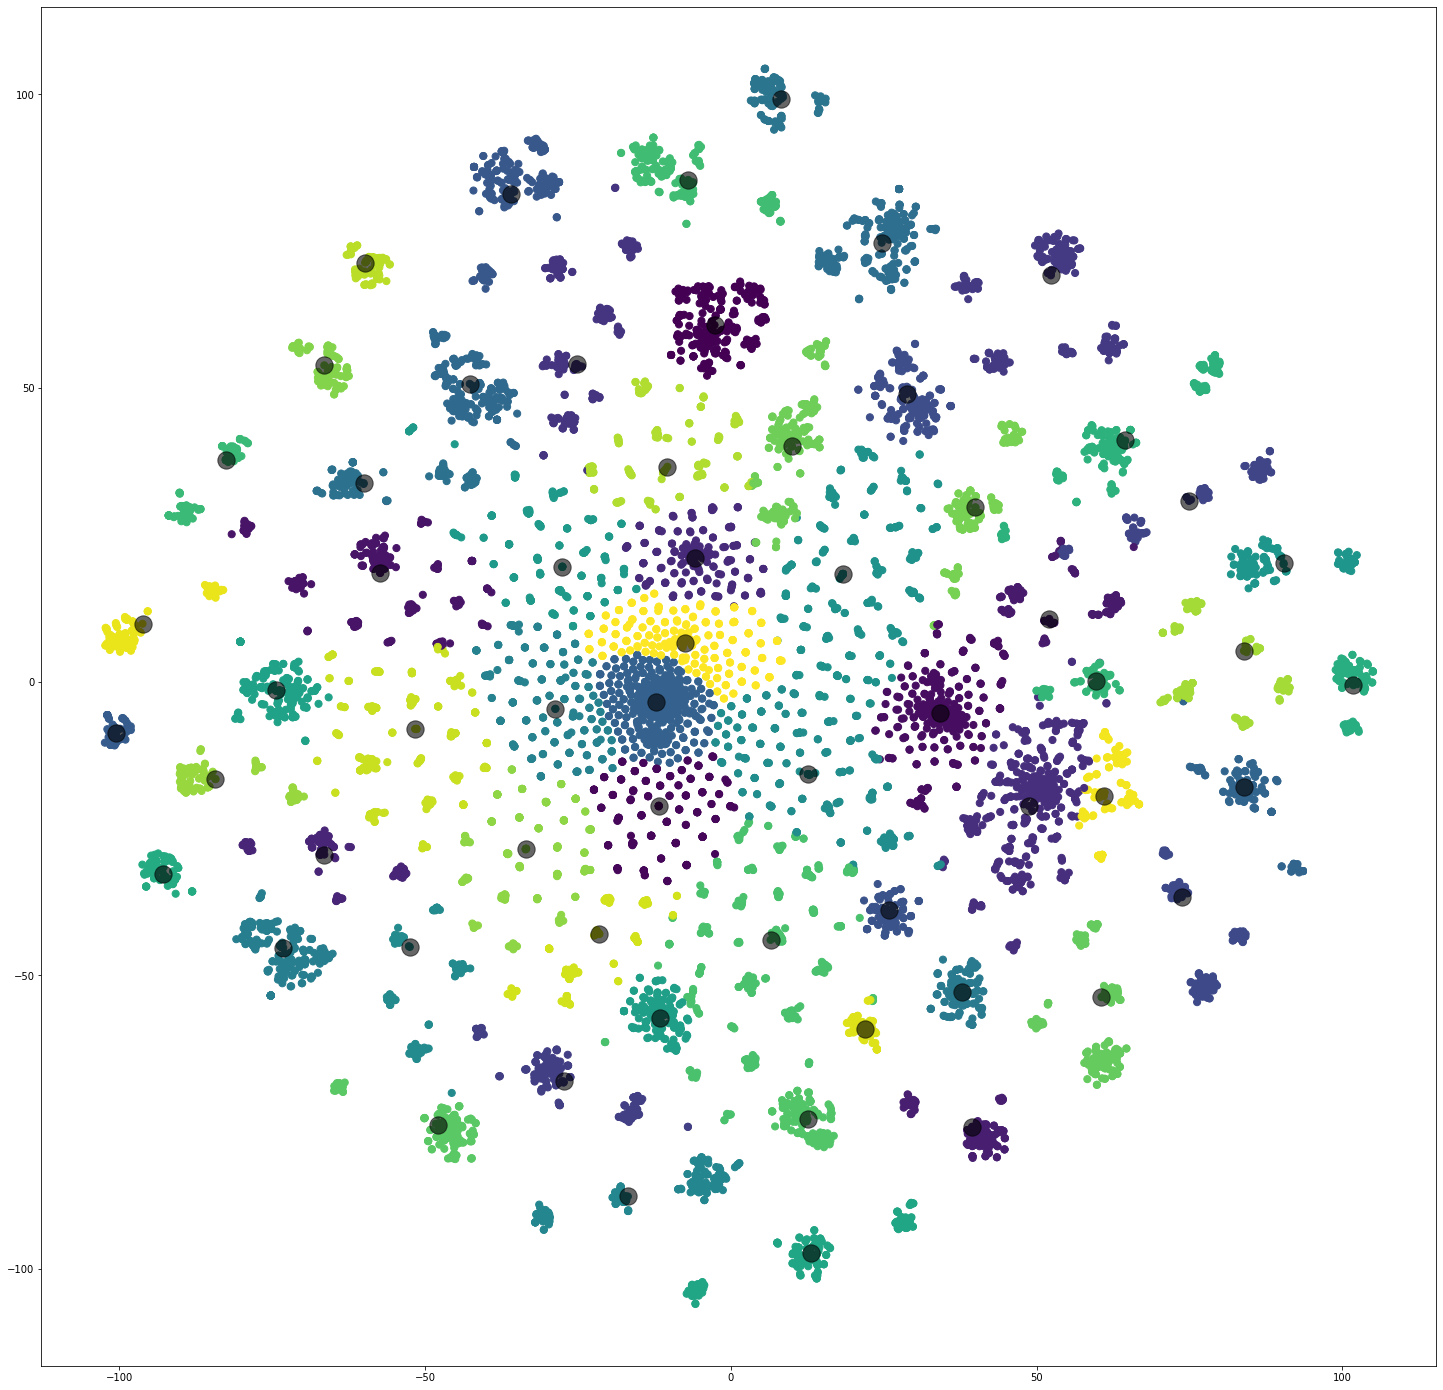

In [13]:
n_components = 60 # Изменяя это значение, меняешь количество кластеров

def id_min_gnn(density,id,df):
  vac = 0
  name = []
  rm = []
  min = np.inf
  k = pd.DataFrame({'id': id, 'density': density,})
  for i in k.sort_values(by = 'density', axis = 0,ascending= False).id[:5]:
    for item2,index in enumerate(df.index):
      if i == index:
        vac = df_i.iloc[item2]
        name.append(vac['name'])
        sk.append(vac['skills'])
        break
  return name

from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal as mvn
random_state = 0

methods = [TSNE(2, random_state = random_state)]
sklearn_pca = PCA(n_components = 2)
Y_sklearn = methods[0].fit_transform(vector)
gmm = GaussianMixture(n_components=n_components, covariance_type='full').fit(Y_sklearn)
prediction_gmm = gmm.predict(Y_sklearn)
probs = gmm.predict_proba(Y_sklearn)

min_vac = []
centers = np.zeros((n_components,2))
for i in range(n_components):
    density = mvn(cov=gmm.covariances_[i], mean=gmm.means_[i]).logpdf(Y_sklearn)
    centers[i, :] = Y_sklearn[np.argmax(density)]
    min_vac.append(id_min_gnn(density,id,df_i))
plt.figure(figsize = (25,25))
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],c=prediction_gmm ,s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);
#plt.savefig('GMM.png')

In [14]:
sec = []
for i in range(n_components):
  print('Кластер:',i)
  for k in min_vac[i]:
    print(k)
  vacs = []
  sq = []
  for j in range(prediction_gmm.shape[0]):
    if prediction_gmm[j] == i:
      vacs.append(id[j])
      sq.append(vector[j])
  print('Количество вакансий в кластере -', len(vacs))
  skill_pvt = skills \
              .query('id in @vacs') \
              .groupby(by='skill', as_index=False) \
              .agg({'name_sk':'count'}) \
              .sort_values(by='name_sk', ascending=False).head(20)
  qqq = pd.DataFrame(sq)
  freq = []
  for k in qqq.columns:
    freq.append(sum(qqq[qqq.columns[k]]))
  freq = pd.DataFrame(freq)
  freq = freq.sort_values(by = freq.columns[0], axis = 0,ascending= False)
  sec.append(skill_pvt)
  kkk = freq.index[:20]
  print( )
  print('Топ скилов отсортированных по позиции и встречаемости')
  for q in kkk:
    print(sk_filtr.skill[q])
  print( )
  print('Топ скилов отсортированных по встречаемости (name_sk - сколько раз скилл встретился в кластере')
  print(skill_pvt)
  print()

Кластер: 0
Flutter мобильный разработчик
C# разработчик (CRM)
Python Backend разработчик
Frontend разработчик (виртуализация)
Python backend developer (middle)
Количество вакансий в кластере - 290

Топ скилов отсортированных по позиции и встречаемости
Git 
Linux 
MySQL 
PHP 
PostgreSQL 
ООП 
JavaScript 
Python 
Java 
HTML 
CSS 
Docker 
Английский язык 
TypeScript 
Atlassian Jira 
Тестирование 
Postman 
React 
REST 
Delphi 

Топ скилов отсортированных по встречаемости (name_sk - сколько раз скилл встретился в кластере
                            skill  name_sk
150                          Git        73
307                          SQL        61
255                   PostgreSQL        50
210                        Linux        41
246                          PHP        38
198                   JavaScript        37
232                        MySQL        35
262                       Python        33
195                         Java        33
27          1 С программирование        28
433 